## Comparison of different cases of DGM inversion with nonlinear forward operator

In [1]:
import os
from pathlib import Path
import numpy as np
import torch
import torch.optim as optim
import random
import time
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
workdir='/home/jorge/Git_projs/VAE_SGD/'
os.chdir(workdir)
# Load from module
from SGD_DGM import SGDsetup,SGD_ninits,SGD_DGM

### Load truth model:

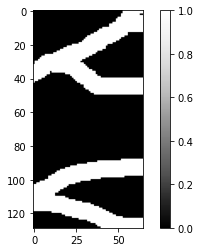

In [4]:
suffix = 'mc2'
ncase = 'no noise' # 'no noise' or 'noise'
mload = Path('test_models/{0}.npy'.format(suffix))
x_true = np.load(mload)
x_true = x_true.reshape(1,1,129,65)

# plot subsurface model
fig, ax = plt.subplots()
clb = ax.imshow(x_true[0,0,:,:], cmap='Greys_r')
fig.colorbar(clb)

# copy truth model:
model_true = np.copy(x_true)

### Simulate synthetic traveltime data:

In [5]:
import pygimli as pg
from pygimli.physics.traveltime import TravelTimeManager

# Acquisition parameters
bh_spacing = 6.5
bh_length = 12.5
sensor_spacing = 0.5

depth = -np.arange(sensor_spacing, bh_length+0.01, sensor_spacing)

sensors = np.zeros((len(depth) * 2, 2))  # two boreholes
sensors[:len(depth), 0] = 0.0  # x
sensors[len(depth):, 0] = bh_spacing  # x
sensors[:, 1] = np.hstack([depth] * 2)  # y

In [6]:
from itertools import product
numbers = np.arange(len(depth))
rays = list(product(numbers, numbers + len(numbers)))

# Empty container
scheme = pg.DataContainer()

# Add sensors
for sen in sensors:
    scheme.createSensor(sen)

# Add measurements
rays = np.array(rays)
scheme.resize(len(rays))
scheme.add("s", rays[:, 0])
scheme.add("g", rays[:, 1])
scheme.add("valid", np.ones(len(rays)))
scheme.registerSensorIndex("s")
scheme.registerSensorIndex("g")

Mesh: Nodes: 8580 Cells: 8385 Boundaries: 16964
16.666666666666668


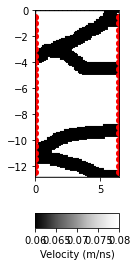

In [7]:
mygrid = pg.meshtools.createMesh2D(x = np.linspace(0.0, 6.5, 66), y = np.linspace(0.0, -12.9, 130))
#mygrid.createNeighbourInfos()
print(mygrid)
# read channels simulation:
model_true = np.reshape(x_true,np.size(x_true))
model_true = 0.06 + 0.02*(1-model_true) # m/ms
mvel = model_true
mslow = 1.0/mvel
print(np.max(mslow))
#ax, _ = pg.show(mygrid, hold=True)
ax, _ = pg.show(mygrid, mvel, label="Velocity (m/ns)", logScale=False, hold=True, cMap='Greys_r')
ax.plot(sensors[:, 0], sensors[:, 1], "ro")

In [8]:
# set traveltime forward model
ttfwd = TravelTimeManager()
resp = ttfwd.simulate(mesh=mygrid, scheme=scheme, slowness=mslow)
ttfwd.applyData(resp)
print(ttfwd.fop.data)

31/07/20 - 16:11:22 - pyGIMLi - INFO - Creating refined mesh (secnodes: 2) to solve forward task.


Data: Sensors: 50 data: 625, nonzero entries: ['g', 's', 't', 'valid']


In [9]:
# noise cases:
sim_true = ttfwd.fop.data.get("t") # ns
if ncase == 'noise':
    # add synthetic noise
    noise_lvl = 0.25
    #nnoise = noise_lvl*np.random.randn(len(sim_true))
    nnoise = np.load('noiserealz.npy') # ns
    sim_true = sim_true + noise_lvl*nnoise # noise_lvl scales the noise.
    print(noise_lvl*nnoise[:10]) # ns
    noisestr = '_noise'
elif ncase == 'no noise':
    noisestr = ''
    
print(sim_true[:10]) # ns

10 [87.13997650882436, 88.85231383473649, 88.06465116064848, 89.57799557331239, 90.59223094936465, 92.54180948685604, 94.60954535709703, 97.46453959380602, 103.65961129410708, 109.95063580724003]


### Set forward model for inversion:

In [10]:
# set traveltime forward model
tt = TravelTimeManager()
scheme.add("t",sim_true)
#scheme.add("err",nnoise)
scheme.add("valid",np.ones(len(sim_true)))
#tt.applyData(scheme)
tt.fop.data = scheme
tt.applyMesh(mygrid, secNodes=3)
tt.velocity = pg.Vector(tt.fop.mesh().cellCount(), 70.0)
tt.inv.model = pg.Vector(tt.fop.mesh().cellCount(), 70.0)
#tt.fop.setThreadCount(6) # using max number of threads causes sometimes segmentation fault
tt.fop.createJacobian(1./tt.velocity)

31/07/20 - 16:11:30 - pyGIMLi - INFO - Found 1 regions.
31/07/20 - 16:11:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
31/07/20 - 16:11:30 - pyGIMLi - INFO - Creating refined mesh (secnodes: 3) to solve forward task.


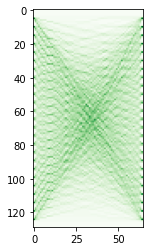

In [11]:
# Sensitivity:
one = pg.Vector(tt.fop.data.size(), 1.)
sensit = np.array(tt.fop.jacobian().transMult(one))
fig, ax = plt.subplots()
ax.imshow(sensit.reshape(129,65), cmap='Greens')

(<matplotlib.axes._subplots.AxesSubplot at 0x7f843fbf6c88>,
 <matplotlib.colorbar.Colorbar at 0x7f843fb68748>)

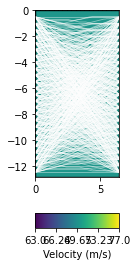

In [12]:
tt.showRayPaths()

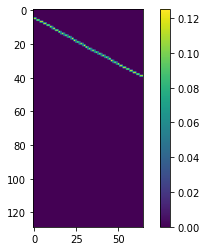

In [13]:
# Show jacobian row (one raypath)
jacrow = np.array(tt.fop.jacobian().row(7))
fig, ax = plt.subplots()
cpj = ax.imshow(jacrow.reshape(129,65))
fig.colorbar(cpj)

In [14]:
jac_expanded = np.zeros((len(sim_true),tt.inv.parameterCount))
for i in range(len(sim_true)):
    jac_expanded[i,:] = np.array(tt.fop.jacobian().row(i))

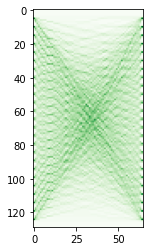

In [15]:
xones = np.ones(len(sim_true))
sensit_ex = jac_expanded.T@xones
fig, ax = plt.subplots()
ax.imshow(sensit_ex.reshape(129,65), cmap='Greens')

### Set up SGD DGM inversion:

In [16]:
DGM = 'VAE' # choose from: 'VAE' or 'SGAN'

In [17]:
# check if GPU is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
#cuda = False

kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
if str(device) == 'cuda':
    cuda=True
else:
    cuda=False

if DGM == 'VAE':
    os.chdir('VAE')
    from autoencoder_in import VAE
    # load parameters of trained VAE
    gpath = 'VAE_inMSEeps100r1e3.pth'
    dnnmodel = VAE(cuda=cuda, gpath=gpath)
    for param in dnnmodel.parameters():
        param.requires_grad = False
    dnnmodel.to(device)
    dnnmodel.eval()
    netG = dnnmodel.decode
    os.chdir(workdir)
    iload = Path('test_models/zinitVAE500.npy')
    
elif DGM == 'SGAN':
    os.chdir('SGAN')
    from generator import Generator
    # load parameters of trained SGAN
    gpath = 'netG_epoch_36.pth'
    dnnmodel = Generator(cuda=cuda, gpath=gpath).to(device)
    for param in dnnmodel.parameters():
        param.requires_grad = False
    dnnmodel.to(device)
    dnnmodel.eval()
    netG = dnnmodel.forward
    os.chdir(workdir)
    iload = Path('test_models/zinitSGAN500.npy')
    
else:
    print('not a valid DGM')

In [18]:
# set global constants
SGDpars = SGDsetup() # initialize data object containing SGD parameters
SGDpars.d = sim_true # "true" data (with or without added noise)
SGDpars.ninits = 1 # number of initial models to test for convergence (for inversion of a single model set to 1)
SGDpars.fwd = 'nonlinear' # either: 'linear' or 'nonlinear'
SGDpars.tt = tt # Nonlinear forward model provided as TravelTimeManager in PyGIMLi
SGDpars.device = device # device to use with pytorch

In [19]:
SGDpars.epochs = 30 # number of epochs (total number of iterations is n_eps*(ndata/batch_size))
SGDpars.batch_size = 25 # size of data batch (must be an integer factor of ndata)
SGDpars.zinit = np.load(iload) # load initial models (latents)
SGDpars.DGM = DGM
SGDpars.gen = netG # generator function from DGM
SGDpars.reg = 'ring' # use 'ring', 'origin' or 'none'
SGDpars.lr = 0.1
SGDpars.optimizer = 'SGD' # use 'SGD' or 'Adam'
SGDpars.clr = 0.8
SGDpars.lam = 10.0
SGDpars.clam = 0.99
SGDpars.step_eps = 5 # number of epochs for which to decrease learning rate and reg. factor
SGDpars.truemodel = x_true
t0 = time.time()
dRMSEs,mRMSEs,models_costmin,zs = SGD_ninits(SGDpars)
tf = time.time()-t0
print('\ncomputation time: {0:.1f} secs.'.format(tf))

DGM: VAE, epochs: 30, iterations: 750, batch_size: 25, step_eps: 5 
lr: 1.0e-01,  clr: 0.800, reg: ring, lam: 1.0e+01,  clam: 0.990, optimizer: SGD 

it: 0, RMSE: 6.27462100982666
it: 1, RMSE: 4.401135444641113
it: 2, RMSE: 5.626770973205566
it: 3, RMSE: 4.079039573669434
it: 4, RMSE: 4.71021842956543
it: 5, RMSE: 5.323451995849609
it: 6, RMSE: 4.192489147186279
it: 7, RMSE: 5.169485569000244
it: 8, RMSE: 4.8655524253845215
it: 9, RMSE: 5.639853477478027
it: 10, RMSE: 3.858022689819336
it: 11, RMSE: 4.1537933349609375
it: 12, RMSE: 4.333611011505127
it: 13, RMSE: 3.9290366172790527
it: 14, RMSE: 5.34514856338501
it: 15, RMSE: 3.8748412132263184
it: 16, RMSE: 5.814337730407715
it: 17, RMSE: 3.638345718383789
it: 18, RMSE: 5.730242729187012
it: 19, RMSE: 3.447927474975586
it: 20, RMSE: 5.218404293060303
it: 21, RMSE: 4.191340923309326
it: 22, RMSE: 4.8681864738464355
it: 23, RMSE: 3.905033588409424
it: 24, RMSE: 5.282151699066162
it: 25, RMSE: 3.3606979846954346
it: 26, RMSE: 5.357015132

it: 244, RMSE: 0.8035817742347717
it: 245, RMSE: 0.7515127658843994
it: 246, RMSE: 0.7627585530281067
it: 247, RMSE: 0.7447918057441711
it: 248, RMSE: 0.6874218583106995
it: 249, RMSE: 0.6929123997688293
it: 250, RMSE: 0.742274284362793
it: 251, RMSE: 0.7390267252922058
it: 252, RMSE: 0.7189545035362244
it: 253, RMSE: 0.7037976384162903
it: 254, RMSE: 0.7128844261169434
it: 255, RMSE: 0.8150755167007446
it: 256, RMSE: 0.7136064767837524
it: 257, RMSE: 0.7277642488479614
it: 258, RMSE: 0.7699395418167114
it: 259, RMSE: 0.7667233943939209
it: 260, RMSE: 0.7323876619338989
it: 261, RMSE: 0.7021280527114868
it: 262, RMSE: 0.7017585039138794
it: 263, RMSE: 0.6952270865440369
it: 264, RMSE: 0.7786206603050232
it: 265, RMSE: 0.7095600366592407
it: 266, RMSE: 0.7152121663093567
it: 267, RMSE: 0.6690697073936462
it: 268, RMSE: 0.7358434200286865
it: 269, RMSE: 0.7109187841415405
it: 270, RMSE: 0.6917643547058105
it: 271, RMSE: 0.668060302734375
it: 272, RMSE: 0.6651598215103149
it: 273, RMSE: 0

it: 486, RMSE: 0.5493813753128052
it: 487, RMSE: 0.5409491062164307
it: 488, RMSE: 0.5910941958427429
it: 489, RMSE: 0.5541139245033264
it: 490, RMSE: 0.5688377618789673
it: 491, RMSE: 0.5935319662094116
it: 492, RMSE: 0.5872953534126282
it: 493, RMSE: 0.5879719257354736
it: 494, RMSE: 0.745113730430603
it: 495, RMSE: 0.5930976271629333
it: 496, RMSE: 0.5613430738449097
it: 497, RMSE: 0.5267871022224426
it: 498, RMSE: 0.6200008988380432
it: 499, RMSE: 0.5817629098892212
it: 500, RMSE: 0.5905678272247314
it: 501, RMSE: 0.5466184616088867
it: 502, RMSE: 0.5443339943885803
it: 503, RMSE: 0.5544115304946899
it: 504, RMSE: 0.5352612137794495
it: 505, RMSE: 0.5269907116889954
it: 506, RMSE: 0.5388537645339966
it: 507, RMSE: 0.5416176915168762
it: 508, RMSE: 0.5382536053657532
it: 509, RMSE: 0.5410647988319397
it: 510, RMSE: 0.5507848858833313
it: 511, RMSE: 0.5553167462348938
it: 512, RMSE: 0.5541237592697144
it: 513, RMSE: 0.5352314710617065
it: 514, RMSE: 0.5336294770240784
it: 515, RMSE: 

it: 727, RMSE: 0.4754478931427002
it: 728, RMSE: 0.49038806557655334
it: 729, RMSE: 0.4938797950744629
it: 730, RMSE: 0.4874158501625061
it: 731, RMSE: 0.4710248112678528
it: 732, RMSE: 0.48906180262565613
it: 733, RMSE: 0.5156105160713196
it: 734, RMSE: 0.5080512166023254
it: 735, RMSE: 0.5084887146949768
it: 736, RMSE: 0.5016500353813171
it: 737, RMSE: 0.47471731901168823
it: 738, RMSE: 0.47762489318847656
it: 739, RMSE: 0.4652854800224304
it: 740, RMSE: 0.48313358426094055
it: 741, RMSE: 0.4921152889728546
it: 742, RMSE: 0.47336509823799133
it: 743, RMSE: 0.4831312596797943
it: 744, RMSE: 0.4668371379375458
it: 745, RMSE: 0.471047967672348
it: 746, RMSE: 0.46839722990989685
it: 747, RMSE: 0.46532395482063293
it: 748, RMSE: 0.473577082157135
it: 749, RMSE: 0.4760964810848236
init: 0, dRMSE: 0.4653, mRMSE: 0.2258, ||z||: 6.6055

computation time: 13340.1 secs.


### Plot results of one inversion (one initial model):

accepted model ring clip: 1
lr = 0.1
min for iteration #: 739
min data RMSE: 0.4652854800224304
z norm at min: 6.6054840087890625
z at min:[[-0.486 -0.578  0.015  1.805  0.085  0.457 -0.774  3.294  0.236  0.644
   1.704 -2.313 -1.552  0.621 -0.08  -1.274  3.042 -2.323 -0.576 -0.06 ]]


Text(0.5, 0, 'iteration')

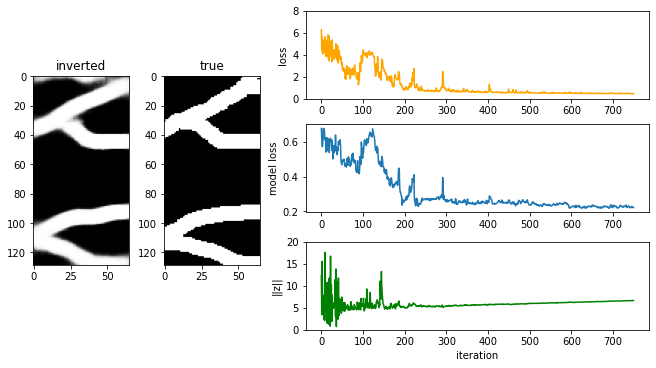

In [20]:
# Extract values in minimum for each initial model:
dRMSEs_min = []
zs_min = []
for i in range(len(dRMSEs)):
    it_min = np.argmin(dRMSEs[i])
    dRMSEs_min.append(dRMSEs[i][it_min])
    zs_min.append(zs[i][it_min])

# Number of accepted models:
updict = {'mc1':0.620,'mc2':0.757,'mc3':1.440,'mv1':1.119,'mv2':1.046,'mv3':1.363}
uplim = updict[suffix]
acmods = np.sum(np.array(dRMSEs_min)<=uplim)
print('accepted model ring clip: {0}'.format(acmods))

# Plot dRMSE vs iterations for one model.
mi = 0
datcost = dRMSEs[mi]
modelcost = mRMSEs[mi]
it_min = np.argmin(datcost)
print('lr = {0}'.format(SGDpars.lr))
print('min for iteration #: {0}'.format(it_min))
print('min data RMSE: {0}'.format(dRMSEs_min[mi]))
print('z norm at min: {0}'.format(np.linalg.norm(zs_min[mi])))
with np.printoptions(precision=3, suppress=True):
    print('z at min:{0}'.format(zs_min[mi]))

# Get znorms vs. iterations
znorms = np.zeros(len(zs[0]))
for i in range(len(znorms)):
    znorms[i] = np.linalg.norm(zs[mi][i][:][0])

# joint subplot
fig = plt.figure(figsize=(9,5), constrained_layout=True)
grid = fig.add_gridspec(3,4)

# first
ax = fig.add_subplot(grid[:,0])
ax.imshow(models_costmin[mi], cmap='Greys_r')
ax.set_title('inverted')

# second
ax = fig.add_subplot(grid[:,1])
ax.imshow(x_true[0,0,:,:], cmap='Greys_r')
ax.set_title('true')

# third
ax = fig.add_subplot(grid[0,2:])
ax.plot(datcost, c='orange')
ax.set_ylim((0.0,8.0))
ax.set_ylabel('loss')

# fourth
ax = fig.add_subplot(grid[1,2:])
ax.plot(modelcost)
#ax.set_ylim((0.0,1.0))
ax.set_ylabel('model loss')

# fifth
ax = fig.add_subplot(grid[2,2:])
ax.plot(znorms,c='g')
ax.set_ylim((0.0,20.0))
ax.set_ylabel('||z||')
ax.set_xlabel('iteration')

### Save results (required for plots in manuscript):

In [21]:
# create directory first time or only use as target for save when it already exists:
sdir = 'Results_nonlinear{0}'.format(noisestr)
if sdir not in os.listdir():
    os.mkdir(sdir)

In [22]:
# save all
# string for SGD parameters:
if SGDpars.clr<1.0:
    sreg = 'd' # decreasing learning rate
else:
    sreg = 'n'

if SGDpars.batch_size == 625:
    bat = 'n' # no data batching
else:
    bat = 'b'

ky = DGM[0]+SGDpars.optimizer[0]+bat+SGDpars.reg[0]+sreg

# save as numpy arrays
np.save(Path('{2}/dRMSEs_{0}_{1}.npy'.format(ky,suffix,sdir)),np.array(dRMSEs))
np.save(Path('{2}/mRMSEs_{0}_{1}.npy'.format(ky,suffix,sdir)),np.array(mRMSEs))
np.save(Path('{2}/modsmin_{0}_{1}.npy'.format(ky,suffix,sdir)),np.array(models_costmin))
np.save(Path('{2}/zs_{0}_{1}.npy'.format(ky,suffix,sdir)),np.array(zs))

print('saved for {0}, case: {1}, in dir: {2}'.format(suffix,ky,sdir))

saved for mc2, case: VSbrd, in dir: Results_nonlinear


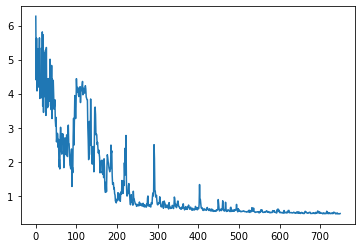

In [23]:
# check save
dRMSEloaded = np.load(Path('{2}/dRMSEs_{0}_{1}.npy'.format(ky,suffix,sdir)))
plt.plot(dRMSEloaded[0,:])